In [1]:
# (1) ライブラリの読み出し
library("tidyverse")
library("broom")

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.3     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.0     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [2]:
# (2) データの読み込み
email_data <- read_csv("http://www.minethatdata.com/Kevin_Hillstrom_MineThatData_E-MailAnalytics_DataMiningChallenge_2008.03.20.csv")

# (3) ルールによるメールの配信を行ったログを作成
## データの整形とrunning variableの追加
male_data <- email_data %>%
  filter(segment %in% c("Mens E-Mail","No E-Mail")) %>%
  mutate(treatment = ifelse(segment == "Mens E-Mail", 1, 0),
         history_log = log(history))

male_data |> head()

Rows: 64000 Columns: 12

── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (4): history_segment, zip_code, channel, segment
dbl (8): recency, history, mens, womens, newbie, visit, conversion, spend


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,history_log
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,3) $200 - $350,329.08,1,1,Rural,1,Web,No E-Mail,0,0,0,0,5.796301
9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0,1,6.515942
9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0,1,6.514816
2,2) $100 - $200,101.64,0,1,Urban,0,Web,Mens E-Mail,1,0,0,1,4.621437
4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0,0,5.486538
3,1) $0 - $100,58.13,1,0,Urban,1,Web,No E-Mail,1,0,0,0,4.062682


In [3]:
## cut-off の値を指定
threshold_value <- 5.5

## ルールによる介入を再現したデータを作成
## cut-offよりrunning variableが大きければが配信されたデータのみ残す
## 逆の場合には配信されなかったデータのみ残す
## running variableを0.1単位で区切ったグループわけの変数も追加しておく
rdd_data <- male_data %>%
  mutate(history_log_grp = round(history_log/0.1,0)*0.1) %>%
  filter(((history_log > threshold_value) &
            (segment == "Mens E-Mail")) |
           (history_log <= threshold_value) &
           (segment == "No E-Mail"))

rdd_data |> head()

recency,history_segment,history,mens,womens,zip_code,newbie,channel,segment,visit,conversion,spend,treatment,history_log,history_log_grp
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,5) $500 - $750,675.83,1,0,Rural,1,Web,Mens E-Mail,0,0,0,1,6.515942,6.5
9,5) $500 - $750,675.07,1,1,Rural,1,Phone,Mens E-Mail,0,0,0,1,6.514816,6.5
4,3) $200 - $350,241.42,0,1,Rural,1,Multichannel,No E-Mail,0,0,0,0,5.486538,5.5
3,1) $0 - $100,58.13,1,0,Urban,1,Web,No E-Mail,1,0,0,0,4.062682,4.1
5,"6) $750 - $1,000",828.42,1,0,Surburban,1,Multichannel,Mens E-Mail,0,0,0,1,6.719520,6.7
9,1) $0 - $100,29.99,0,1,Surburban,1,Phone,No E-Mail,0,0,0,0,3.400864,3.4


`summarise()` has grouped output by 'history_log_grp'. You can override using the `.groups` argument.



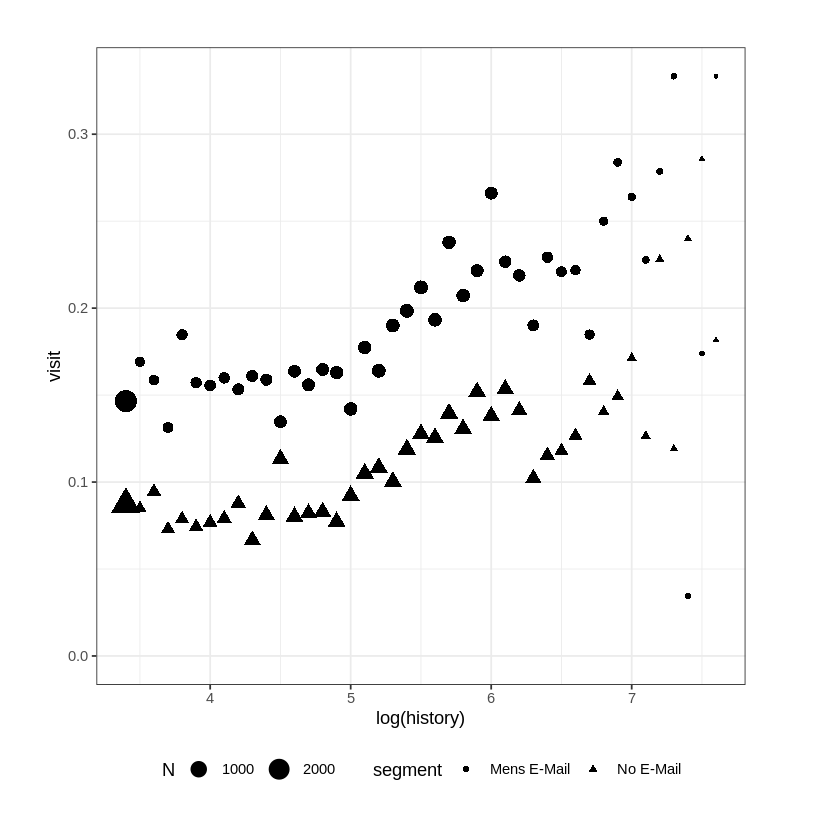

In [4]:
# (4) RCTデータとRDDデータの傾向の比較
## running variableとサイト来訪率のプロット(RCTデータ)
male_data %>%
  mutate(history_log_grp = round(history_log/0.1,0)*0.1) %>%
  group_by(history_log_grp, segment) %>%
  summarise(visit = mean(visit),
            N = n()) %>%
  filter(N > 10) %>%
  ggplot(aes(y = visit,
             x = history_log_grp,
             shape = segment,
             size = N)) +
  geom_point() +
  ylim(0,NA) +
  theme_bw() +
  xlab("log(history)") +
  theme(plot.title = element_text(hjust = 0.5),
        legend.position = "bottom",
        plot.margin = margin(1,2,1,1, "cm"))

`summarise()` has grouped output by 'history_log_grp'. You can override using the `.groups` argument.



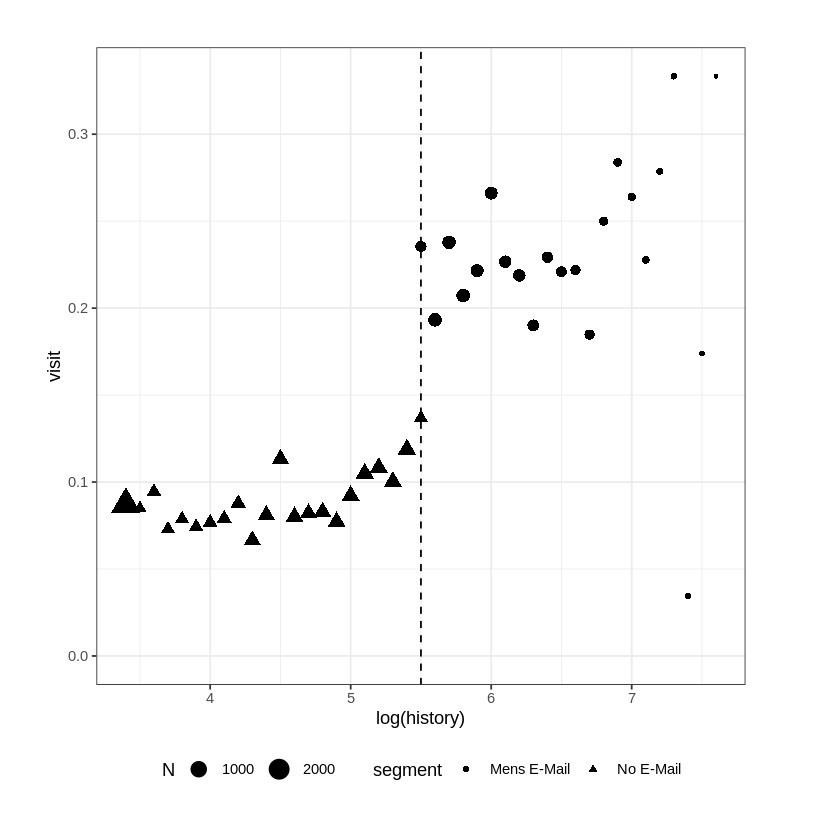

In [5]:
## running variableとサイト来訪率のプロット(RDDデータ)
rdd_data %>%
  group_by(history_log_grp, segment) %>%
  summarise(visit = mean(visit),
            N = n()) %>%
  filter(N > 10) %>%
  ggplot(aes(y = visit,
             x = history_log_grp,
             shape = segment,
             size = N)) +
  geom_point() +
  geom_vline(xintercept = 5.5, linetype = 2) +
  ylim(0,NA) +
  theme_bw() +
  xlab("log(history)") +
  theme(plot.title = element_text(hjust = 0.5),
        legend.position = "bottom",
        plot.margin = margin(1,2,1,1, "cm"))

In [6]:
# (5) 集計による分析
## RCTデータでの比較
rct_data_table <- male_data %>%
  filter(history_log > 5, history_log < 6) %>%
  group_by(treatment) %>%
  summarise(count = n(),
            visit = mean(visit))
## RDDデータでの比較
rdd_data_table <- rdd_data %>%
  group_by(treatment) %>%
  summarise(count = n(),
            visit_rate = mean(visit))

rct_data_table |> head()
rdd_data_table |> head()
# RCTによると介入の効果は0.8程度のはずだが、
# そうでないデータは1.3程度になってしまっている

treatment,count,visit
<dbl>,<int>,<dbl>
0,7167,0.1212502
1,7135,0.2004205


treatment,count,visit_rate
<dbl>,<int>,<dbl>
0,13926,0.09069367
1,7366,0.22400217


In [7]:
# (6) 回帰分析による分析
## 線形回帰による分析
rdd_lm_reg <- rdd_data %>%
  mutate(treatment = ifelse(segment == "Mens E-Mail", 1, 0)) %>%
  lm(data = ., formula = visit ~ treatment + history_log) %>%
  summary() %>%
  tidy() %>%
  filter(term == "treatment")

rdd_lm_reg
# 回帰分析を用いると不連続点周辺をある程度重要視して効果を推定してくれる
# それでもバイアスがある

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
treatment,0.113672,0.007982594,14.23998,8.400022e-46


In [8]:
## 非線形回帰による分析
library("rddtools")
# rddtoolsがinstallできねぇ...どうなってるんだ
nonlinear_rdd_data <- rdd_data(y = rdd_data$visit,
                               x = rdd_data$history_log,
                               cutpoint = 5.5)

nonlinear_rdd_ord4 <- rdd_reg_lm(rdd_object=nonlinear_rdd_data, order=4)
nonlinear_rdd_ord4
plot(nonlinear_rdd_ord4)

ERROR: Error in library("rddtools"): there is no package called ‘rddtools’


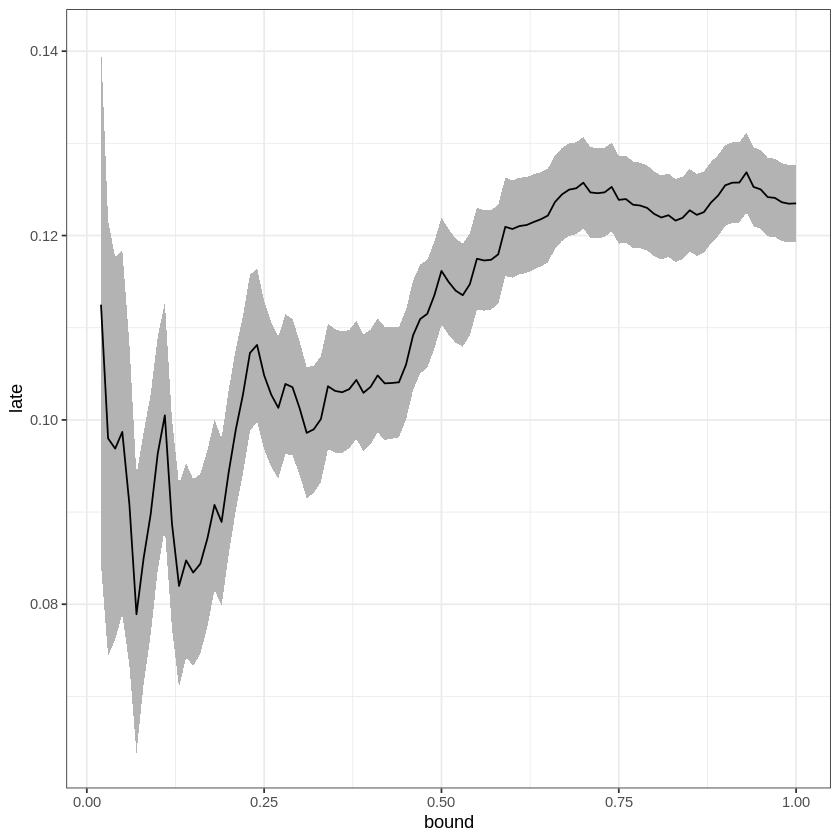

In [9]:
# (7) 分析に使うデータの幅と分析結果のプロット
bound_list <- 2:100/100
result_data <- data.frame()
for(bound in bound_list){
  out_data <- rdd_data %>%
    filter(between(history_log, 5.5 - bound, 5.5 + bound)) %>%
    group_by(treatment) %>%
    summarise(count = n(),
              visit_rate = mean(visit),
              sd = sd(visit))

  late <- out_data$visit_rate[2] - out_data$visit_rate[1]
  N <- sum(out_data$count)
  se <- sqrt(sum(out_data$visit_rate^2))/sqrt(N)
  result_data <- rbind(result_data, data.frame(late, bound, N, se))
}

result_data %>%
  ggplot(aes(y = late,
             x = bound)) +
  geom_ribbon(aes(ymax = late + 1.96*se,
                  ymin = late - 1.96*se), fill = "grey70") +
  geom_line() +
  theme_bw()

In [10]:
# (8) nonparametric RDD
## ライブラリの読み込み
library("rdd")
# これもなぜかインストールできませんわね

## non-parametric RDDの実行
rdd_result <- RDestimate(data = rdd_data,
                         formula = visit ~ history_log,
                         cutpoint = 5.5)

## 結果のレポート
summary(rdd_result)

## 結果のプロット
plot(rdd_result)

## manipulat
DCdensity(runvar = rdd_data %>% pull(history_log),
          cutpoint = 5.5,
          plot = FALSE)


ERROR: Error in library("rdd"): there is no package called ‘rdd’
